In [1]:
import pandas as pd
import pyarrow
from datetime import datetime, timedelta
import calendar
from prophet import Prophet
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def nearest_4th_diff(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    if date.day >= 4:
        # If the day of the given date is after the 4th, use the 4th of the same month
        nearest_4th_date = date.replace(day=4)
    else:
        # If the day is on or before the 4th, go to the previous month
        previous_month = date.replace(day=1) - timedelta(days=1)
        nearest_4th_date = previous_month.replace(day=4)
    
    # Calculate the difference in days
    date_diff = (date - nearest_4th_date).days
    return nearest_4th_date.strftime('%Y-%m-%d'), date_diff

## Input data 

In [3]:
input_df=pd.read_parquet('data/input_data.parquet')
input_df=input_df.sort_values(by='date_balance')

In [4]:
input_df[['date_balance','max_dpd']]

,date_balance,max_dpd
1512,2023-06-25,86
1510,2023-06-26,87
1508,2023-06-27,88
1505,2023-06-28,85
1500,2023-06-29,86
...,...,...
12,2024-11-06,82
11,2024-11-07,83
7,2024-11-08,84
5,2024-11-09,85


In [5]:
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

# Shift 'max_dpd' column to get previous day's DPD
input_df['prev_max_dpd'] = input_df['max_dpd'].shift(1)

# Create the flag column
input_df['flag'] = ((input_df['prev_max_dpd'] >= 85) & (input_df['max_dpd'] < 85)).astype(int)

In [6]:
input_df['dpd30_rate_adj'] = input_df['dpd30_rate'].rolling(window=7, min_periods=1).mean()


In [7]:
# input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

# # Define the date range
# start_date = '2024-06-04'
# end_date = '2024-07-03'

# # Filter the DataFrame for rows within the date range
# input_df = input_df[~((input_df['date_balance'] >= start_date) & (input_df['date_balance'] <= end_date))]


## Input holidays 

The data represents the daily rate of DPD30+ for a banking product, with a monthly due date on the 4th of each month. If the customer does not make a payment, the DPD will reach 30 exactly 30 days after the due date. The date_diff variable captures the difference between the current date and the nearest 4th day of the month. For instance, when date_diff = 29 (counting from 0), it indicates a special point for the model to predict, as it is the day before the DPD reaches 30.

In Prophet, holidays are treated as special events that can cause unusual behavior in the time series. 
These events, such as specific dates or occurrences, are modeled separately from the regular trend and seasonality. 
By including holidays as inputs, the model can give more attention to these dates, allowing it to adjust the trend accordingly and account for any spikes or drops that might occur during these periods.
This helps Prophet accurately capture the impact of holidays on the time series, ensuring that these fluctuations are considered in the model's predictions.

In [8]:
holiday_dates = input_df[input_df['flag']==1]['date_balance']

# Define holidays DataFrame for Prophet
holidays = pd.DataFrame({
    'holiday': 'new_cycle',
    'ds': holiday_dates,
    'lower_window': 0,
    'upper_window': 1,
})

In [9]:
holidays

,holiday,ds,lower_window,upper_window
1490,new_cycle,2023-07-03,0,1
1462,new_cycle,2023-07-12,0,1
1441,new_cycle,2023-07-19,0,1
1420,new_cycle,2023-07-26,0,1
1400,new_cycle,2023-08-02,0,1
...,...,...,...,...
97,new_cycle,2024-10-09,0,1
76,new_cycle,2024-10-16,0,1
56,new_cycle,2024-10-23,0,1
33,new_cycle,2024-10-30,0,1


## Trend Overview 

The trend so seasonal fluctuation which drammatically increase on due date ( 4th monthly ) drop after ward


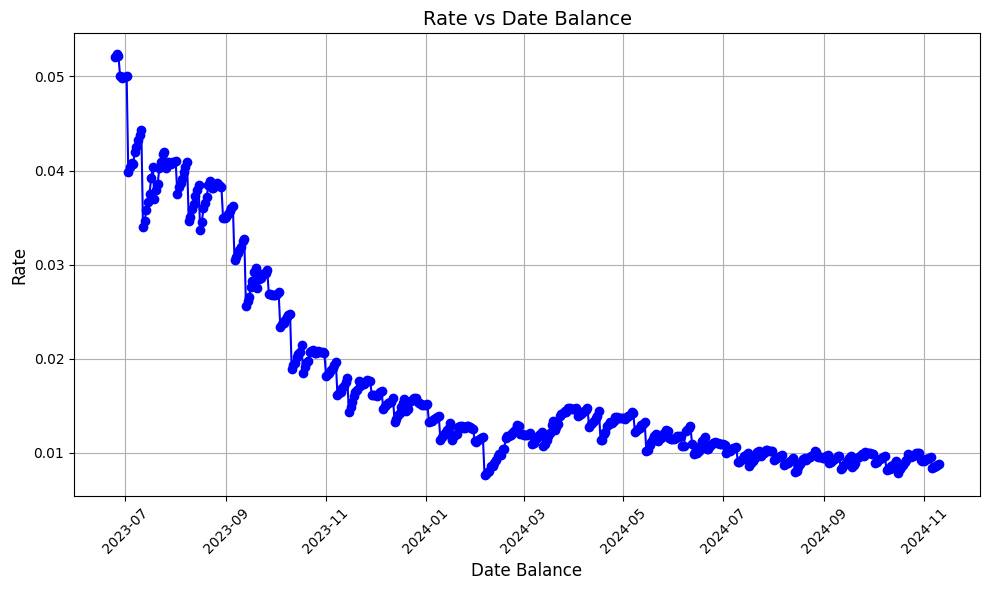

In [12]:
# Assuming input_df is already defined and contains 'date_balance' and 'rate' columns
# First, we will convert 'date_balance' to a datetime object to ensure proper plotting
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

# Plotting the 'rate' values over 'date_balance'
plt.figure(figsize=(10, 6))
plt.plot(input_df['date_balance'], input_df['dpd30_rate'], marker='o', linestyle='-', color='b')

# Adding titles and labels
plt.title('Rate vs Date Balance', fontsize=14)
plt.xlabel('Date Balance', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
print('The trend so seasonal fluctuation which drammatically increase on due date ( 4th monthly ) drop after ward')
# Display the plot
plt.show()

15:53:27 - cmdstanpy - INFO - Chain [1] start processing
15:53:28 - cmdstanpy - INFO - Chain [1] done processing


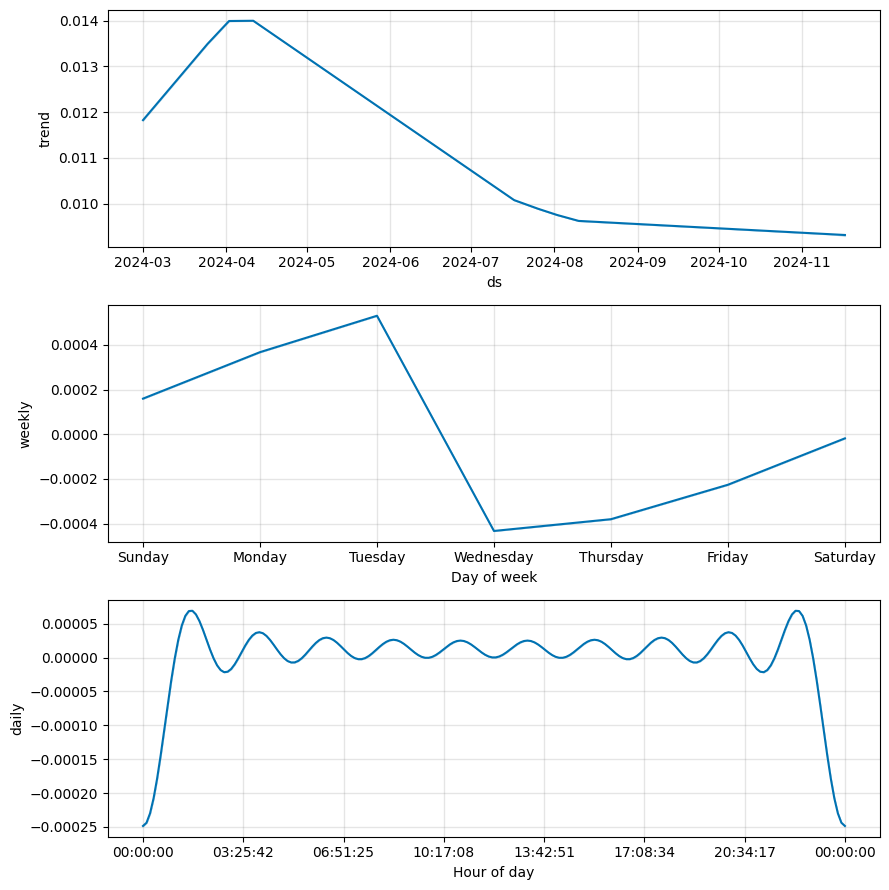

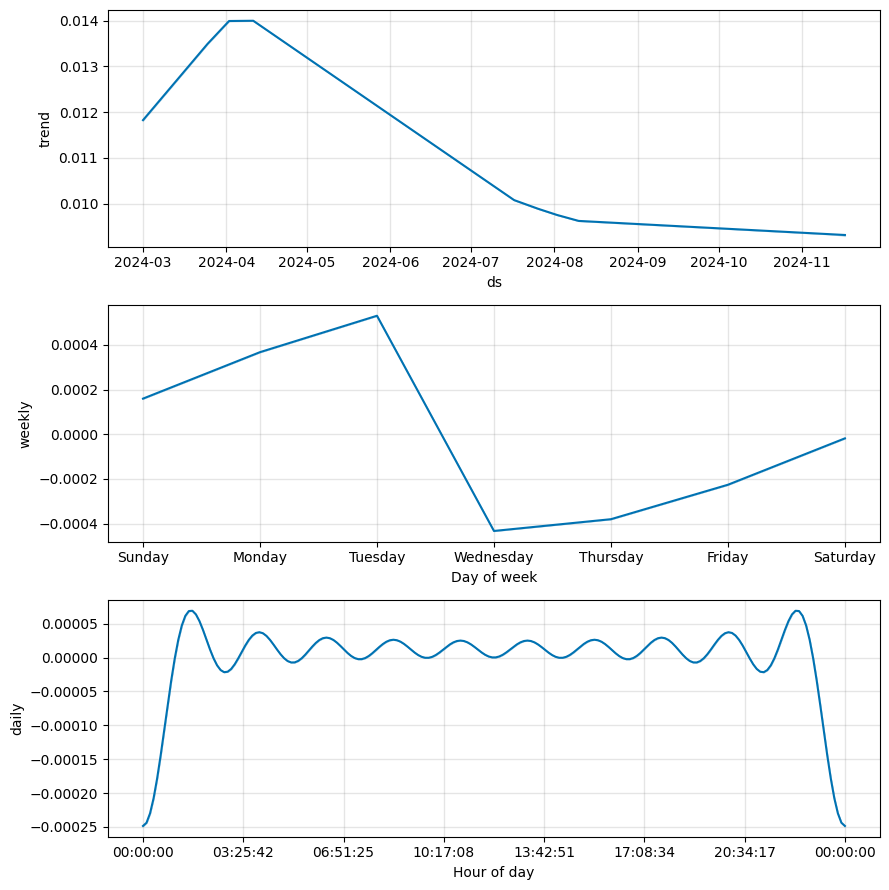

In [102]:
from prophet.plot import plot_components

m = Prophet(daily_seasonality=False)  # Disable automatic daily seasonality
m.add_seasonality(name='daily', period=1, fourier_order=10)  # Add custom daily seasonality
m.fit(df_prophet)

# Forecast future values
future = m.make_future_dataframe(periods=7, freq='D')
forecast = m.predict(future)

# Plot seasonal components
plot_components(m, forecast)


07:45:54 - cmdstanpy - INFO - Chain [1] start processing
07:45:54 - cmdstanpy - INFO - Chain [1] done processing


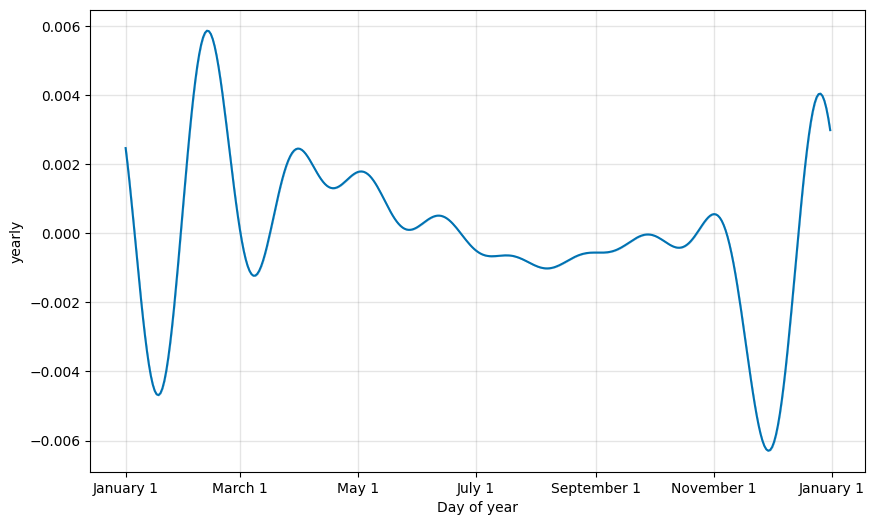

In [11]:
from prophet import Prophet
from prophet.plot import plot_yearly

# Fit the Prophet model
m = Prophet(yearly_seasonality=True)  # Enable yearly seasonality explicitly
m.fit(df_prophet)

# Plot yearly seasonality
fig = plot_yearly(m)


## Baseline model - Daily Rate 

Option 1: Predict fore DPD30 rate in future on daily basis    
Use the most recent data starting from February 2024 to minimize any bias introduced by older data.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
08:30:38 - cmdstanpy - INFO - Chain [1] start processing
08:30:38 - cmdstanpy - INFO - Chain [1] done processing


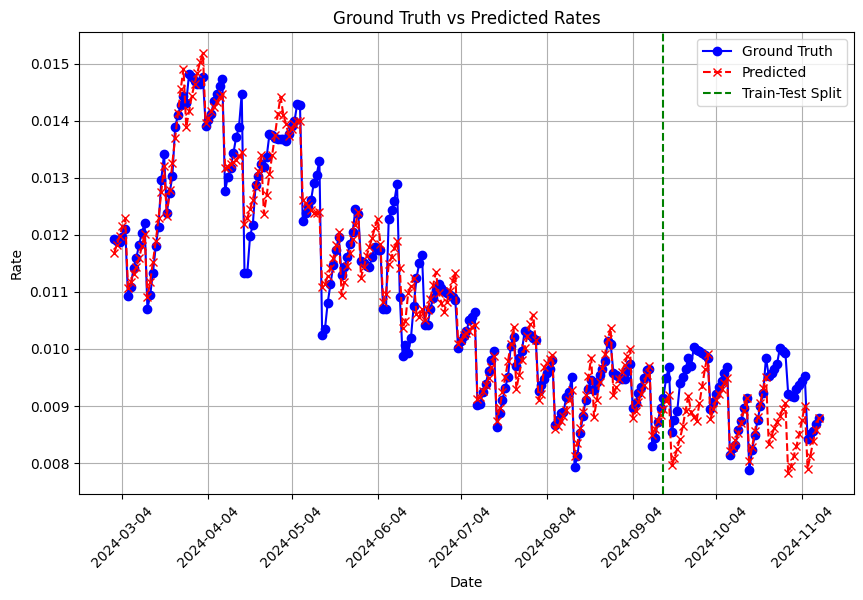

In [110]:


from_date='2024-03-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]

base_date = pd.to_datetime(from_date)
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'dpd30_rate','flag','max_dpd']].rename(columns={'dpd30_rate': 'y'})


# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.78)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]



# Initialize the Prophet model and add 'date_diff' as an additional regressor
#model = Prophet(holidays=holidays,changepoints=changepoint_dates)
model = Prophet(holidays=holidays,
                   growth='linear',                      # Linear growth
                changepoint_range =0.9,
                #seasonality_mode='multiplicative',
    #changepoint_prior_scale=0.001,           # More flexible trend
    #seasonality_prior_scale=10.0,          # Strong seasonality
    holidays_prior_scale=1.0,             # Strong holiday effect
    #seasonality_mode='additive',           # Additive seasonality
    #interval_width=0.95,                   # 95% prediction intervals
    daily_seasonality=False,                # Include daily seasonality
    yearly_seasonality=20                # Include yearly seasonality
               
               )
#model.add_regressor('flag')
#model.add_regressor('max_dpd')
#model.add_seasonality(name='monthly_spike', period=30, fourier_order=4)

# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff','flag','max_dpd']], on='ds', how='left')
future['ds']=future['ds'].astype(str)
future[['nearest_4th', 'date_diff']] = future['ds'].apply(nearest_4th_diff).apply(pd.Series)


# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'dpd30_rate','date_diff','flag','max_dpd']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat']))
mae = mean_absolute_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])
mse = mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['dpd30_rate'] - comparison['yhat']) / comparison['dpd30_rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})



# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))

comparison['ds'] = comparison['ds'].astype(str)


# Plot ground truth and predicted values
plt.plot(comparison['ds'], comparison['dpd30_rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')

# Fill the prediction interval
#plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')

# Add a vertical line for the train-test split
test_start_date = df_test['ds'].iloc[0]  # First date of the test set
plt.axvline(x=test_start_date.strftime('%Y-%m-%d'), color='green', linestyle='--', label='Train-Test Split')

# Set x-axis labels to show only the 4th of each month
tick_dates = [date for date in comparison['ds'] if int(date[5:7]) % 1 == 0 and int(date[8:10]) == 4]
plt.xticks(ticks=tick_dates, rotation=45)

# Title, labels, legend, and grid
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [111]:
display(metrics_df)

,Metric,Value
0,RMSE,4.426834e-04
1,MAE,3.183787e-04
2,MSE,1.959686e-07
3,MAPE,2.994381e+00


## Baseline model - Moving Average 

Option 2:    
From the trend overview section, it is evident that the daily trend fluctuates significantly due to operational activities such as loan disbursement and collections. From a management perspective, the focus is more on the portfolio status at specific points in time (e.g., month-end or year-end) and observing the overall trend, particularly changes in the bad debt rate. To address this, the approach involves smoothing the trend line by applying a n-day moving average (this will be assessed), which is used as the target variable for prediction, aiming to forecast long-term trends.

### Observation period assessment 

The goal is to determine an appropriate time frame for smoothing the trendline.    
A larger time frame provides a smoother curve but may overlook small fluctuations, while a smaller time frame can be too sensitive to short-term variations.

I will try (7/15/21/30) days timeframe to find the differences 

In [79]:
from_date='2024-01-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]


### 7 days 

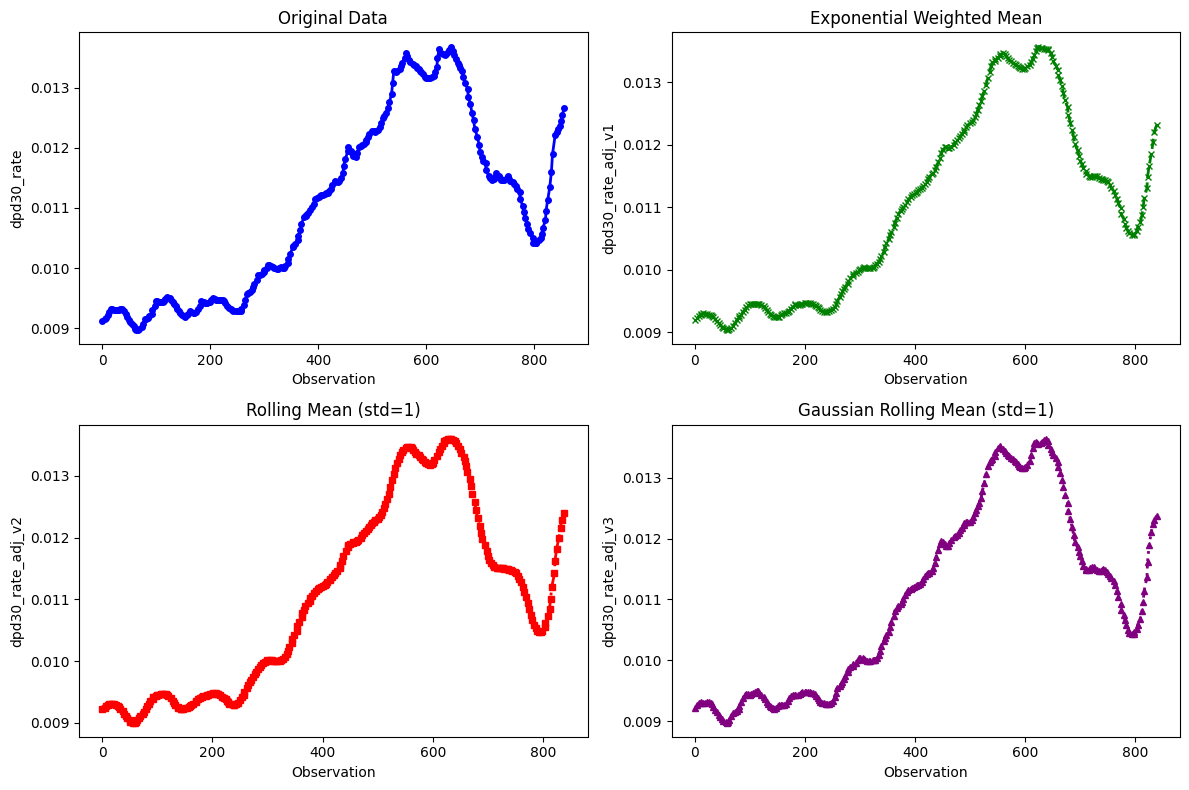

In [100]:
period=7
obs_df['dpd30_rate_adj_v1'] = obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()

# Rolling Mean with std=1.0
obs_df['dpd30_rate_adj_v2'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

# Gaussian Rolling Window (v3)
obs_df['dpd30_rate_adj_v3'] = obs_df['dpd30_rate'].rolling(window=period, win_type='gaussian', center=False).mean(std=1.0)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Original Data
axs[0, 0].plot(obs_df['dpd30_rate'], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)
axs[0, 0].set_title('Original Data')
axs[0, 0].set_xlabel('Observation')
axs[0, 0].set_ylabel('dpd30_rate')

# Plot Exponential Weighted Mean (v1)
axs[0, 1].plot(obs_df['dpd30_rate_adj_v1'], color='green', linewidth=2, linestyle='--', marker='x', markersize=4)
axs[0, 1].set_title('Exponential Weighted Mean')
axs[0, 1].set_xlabel('Observation')
axs[0, 1].set_ylabel('dpd30_rate_adj_v1')

# Plot Rolling Mean (v2)
axs[1, 0].plot(obs_df['dpd30_rate_adj_v2'], color='red', linewidth=2, linestyle='-.', marker='s', markersize=4)
axs[1, 0].set_title('Rolling Mean (std=1)')
axs[1, 0].set_xlabel('Observation')
axs[1, 0].set_ylabel('dpd30_rate_adj_v2')

# Plot Gaussian Rolling Mean (v3)
axs[1, 1].plot(obs_df['dpd30_rate_adj_v3'], color='purple', linewidth=2, linestyle=':', marker='^', markersize=4)
axs[1, 1].set_title('Gaussian Rolling Mean (std=1)')
axs[1, 1].set_xlabel('Observation')
axs[1, 1].set_ylabel('dpd30_rate_adj_v3')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### 15 days 

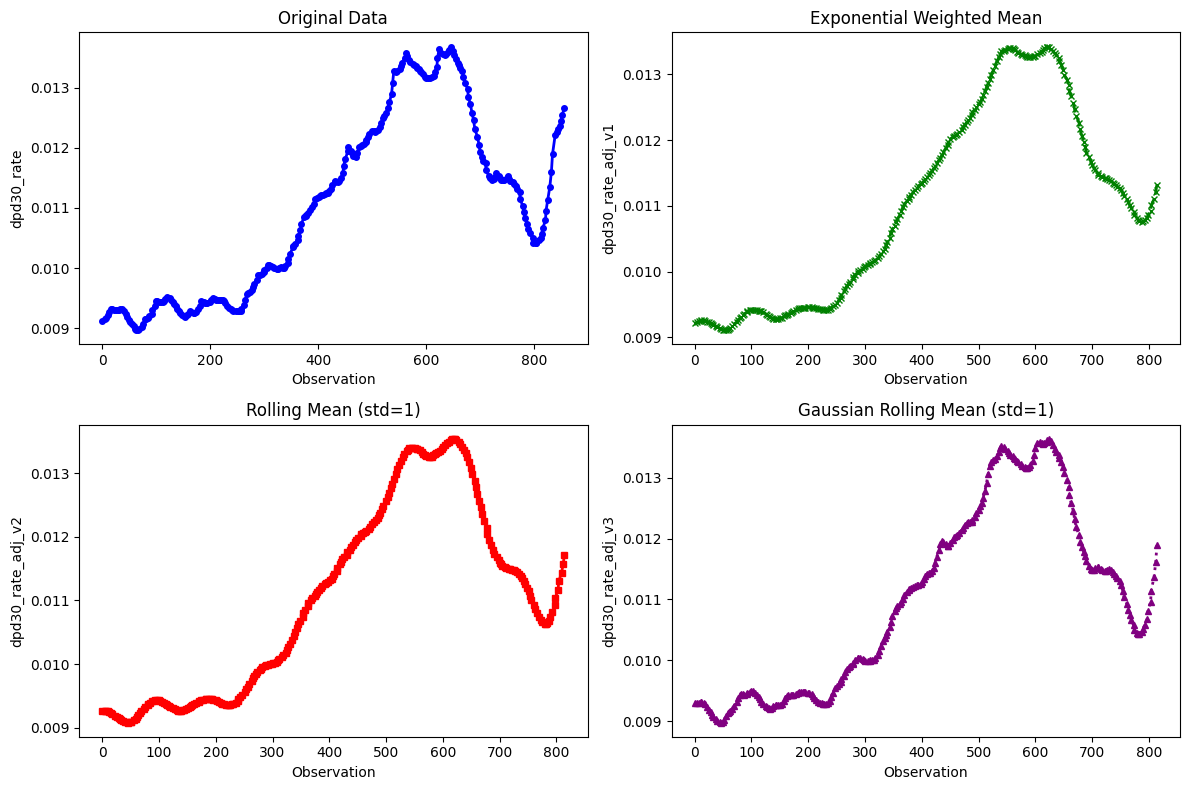

In [99]:
period=15
obs_df['dpd30_rate_adj_v1'] = obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()

# Rolling Mean with std=1.0
obs_df['dpd30_rate_adj_v2'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

# Gaussian Rolling Window (v3)
obs_df['dpd30_rate_adj_v3'] = obs_df['dpd30_rate'].rolling(window=period, win_type='gaussian', center=False).mean(std=1.0)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Original Data
axs[0, 0].plot(obs_df['dpd30_rate'], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)
axs[0, 0].set_title('Original Data')
axs[0, 0].set_xlabel('Observation')
axs[0, 0].set_ylabel('dpd30_rate')

# Plot Exponential Weighted Mean (v1)
axs[0, 1].plot(obs_df['dpd30_rate_adj_v1'], color='green', linewidth=2, linestyle='--', marker='x', markersize=4)
axs[0, 1].set_title('Exponential Weighted Mean')
axs[0, 1].set_xlabel('Observation')
axs[0, 1].set_ylabel('dpd30_rate_adj_v1')

# Plot Rolling Mean (v2)
axs[1, 0].plot(obs_df['dpd30_rate_adj_v2'], color='red', linewidth=2, linestyle='-.', marker='s', markersize=4)
axs[1, 0].set_title('Rolling Mean (std=1)')
axs[1, 0].set_xlabel('Observation')
axs[1, 0].set_ylabel('dpd30_rate_adj_v2')

# Plot Gaussian Rolling Mean (v3)
axs[1, 1].plot(obs_df['dpd30_rate_adj_v3'], color='purple', linewidth=2, linestyle=':', marker='^', markersize=4)
axs[1, 1].set_title('Gaussian Rolling Mean (std=1)')
axs[1, 1].set_xlabel('Observation')
axs[1, 1].set_ylabel('dpd30_rate_adj_v3')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### 21 days 

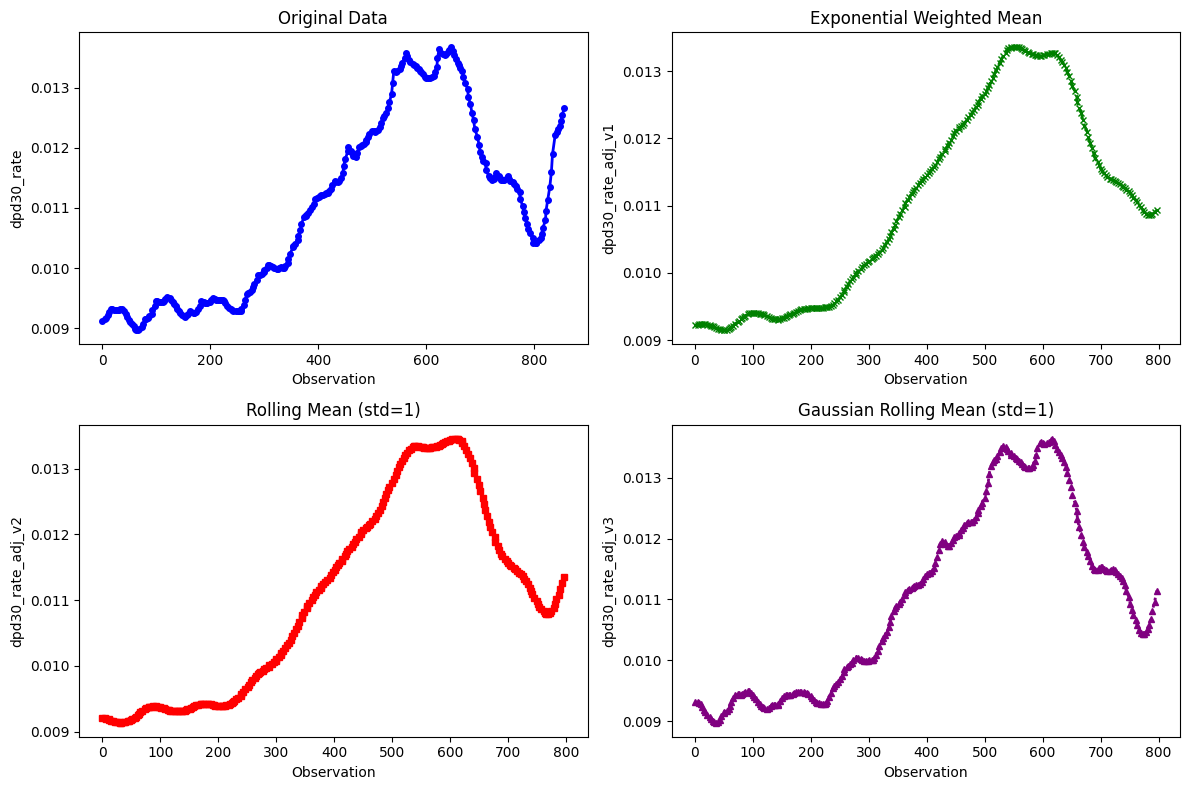

In [98]:
period=21
obs_df['dpd30_rate_adj_v1'] = obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()

# Rolling Mean with std=1.0
obs_df['dpd30_rate_adj_v2'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

# Gaussian Rolling Window (v3)
obs_df['dpd30_rate_adj_v3'] = obs_df['dpd30_rate'].rolling(window=period, win_type='gaussian', center=False).mean(std=1.0)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Original Data
axs[0, 0].plot(obs_df['dpd30_rate'], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)
axs[0, 0].set_title('Original Data')
axs[0, 0].set_xlabel('Observation')
axs[0, 0].set_ylabel('dpd30_rate')

# Plot Exponential Weighted Mean (v1)
axs[0, 1].plot(obs_df['dpd30_rate_adj_v1'], color='green', linewidth=2, linestyle='--', marker='x', markersize=4)
axs[0, 1].set_title('Exponential Weighted Mean')
axs[0, 1].set_xlabel('Observation')
axs[0, 1].set_ylabel('dpd30_rate_adj_v1')

# Plot Rolling Mean (v2)
axs[1, 0].plot(obs_df['dpd30_rate_adj_v2'], color='red', linewidth=2, linestyle='-.', marker='s', markersize=4)
axs[1, 0].set_title('Rolling Mean (std=1)')
axs[1, 0].set_xlabel('Observation')
axs[1, 0].set_ylabel('dpd30_rate_adj_v2')

# Plot Gaussian Rolling Mean (v3)
axs[1, 1].plot(obs_df['dpd30_rate_adj_v3'], color='purple', linewidth=2, linestyle=':', marker='^', markersize=4)
axs[1, 1].set_title('Gaussian Rolling Mean (std=1)')
axs[1, 1].set_xlabel('Observation')
axs[1, 1].set_ylabel('dpd30_rate_adj_v3')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

### 30 days 

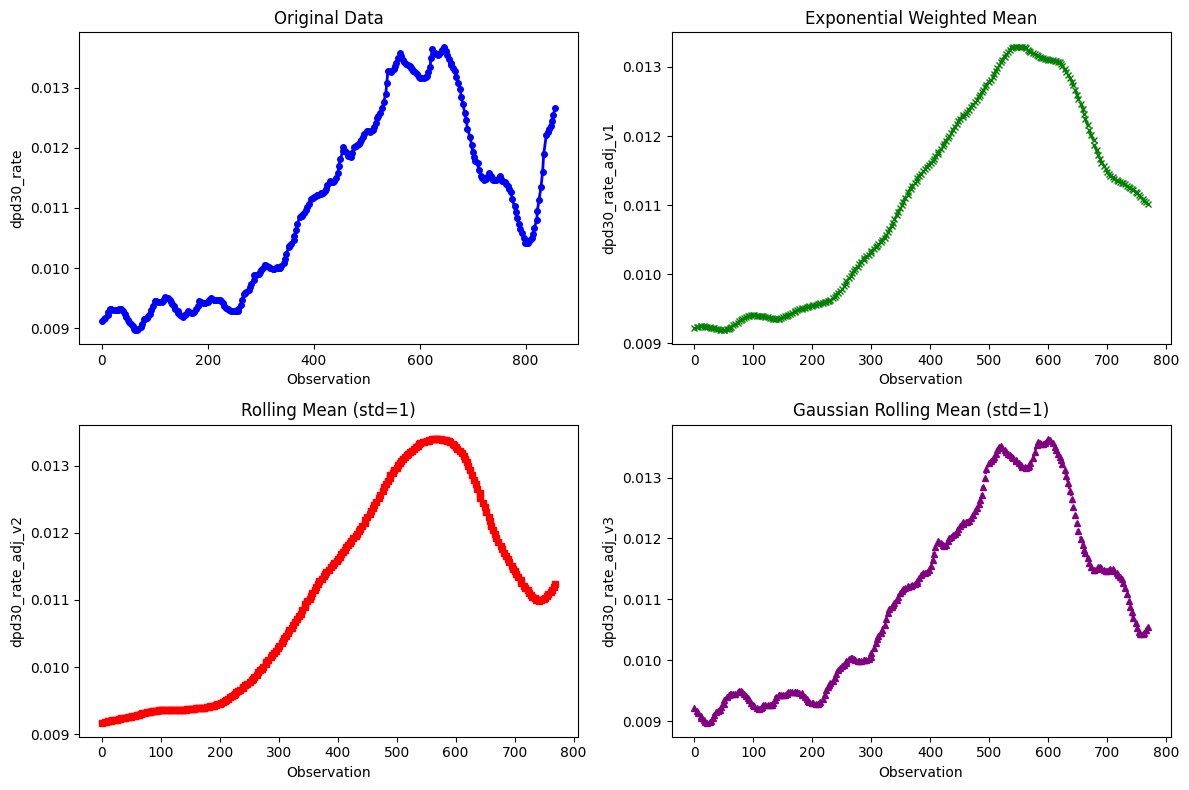

In [97]:
period=30
obs_df['dpd30_rate_adj_v1'] = obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()

# Rolling Mean with std=1.0
obs_df['dpd30_rate_adj_v2'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

# Gaussian Rolling Window (v3)
obs_df['dpd30_rate_adj_v3'] = obs_df['dpd30_rate'].rolling(window=period, win_type='gaussian', center=False).mean(std=1.0)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Original Data
axs[0, 0].plot(obs_df['dpd30_rate'], color='blue', linewidth=2, linestyle='-', marker='o', markersize=4)
axs[0, 0].set_title('Original Data')
axs[0, 0].set_xlabel('Observation')
axs[0, 0].set_ylabel('dpd30_rate')

# Plot Exponential Weighted Mean (v1)
axs[0, 1].plot(obs_df['dpd30_rate_adj_v1'], color='green', linewidth=2, linestyle='--', marker='x', markersize=4)
axs[0, 1].set_title('Exponential Weighted Mean')
axs[0, 1].set_xlabel('Observation')
axs[0, 1].set_ylabel('dpd30_rate_adj_v1')

# Plot Rolling Mean (v2)
axs[1, 0].plot(obs_df['dpd30_rate_adj_v2'], color='red', linewidth=2, linestyle='-.', marker='s', markersize=4)
axs[1, 0].set_title('Rolling Mean (std=1)')
axs[1, 0].set_xlabel('Observation')
axs[1, 0].set_ylabel('dpd30_rate_adj_v2')

# Plot Gaussian Rolling Mean (v3)
axs[1, 1].plot(obs_df['dpd30_rate_adj_v3'], color='purple', linewidth=2, linestyle=':', marker='^', markersize=4)
axs[1, 1].set_title('Gaussian Rolling Mean (std=1)')
axs[1, 1].set_xlabel('Observation')
axs[1, 1].set_ylabel('dpd30_rate_adj_v3')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

A time frame of around 15 to 21 days strikes a balance between capturing trendline variations and achieving smoothness.
And rolling mean has better trendline than other methods

### Last 7 days 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(309, 4)

08:27:22 - cmdstanpy - INFO - Chain [1] start processing
08:27:22 - cmdstanpy - INFO - Chain [1] done processing


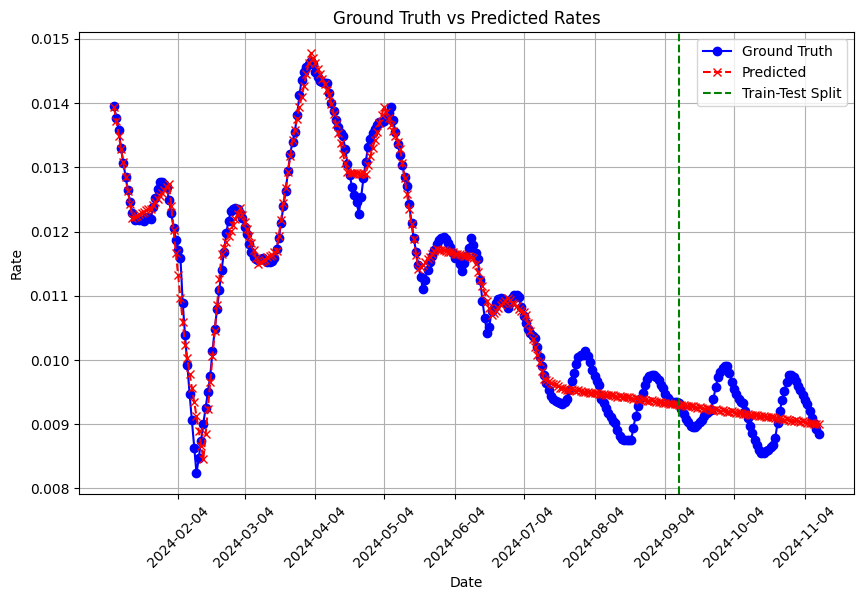

In [103]:
from_date='2024-01-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])
period=7

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]
obs_df['dpd30_rate'] = obs_df['dpd30_rate'].rolling(window=7, center=False).mean(std=0.5)

#obs_df['dpd30_rate']=obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()
obs_df=obs_df[~obs_df['dpd30_rate'].isnull()]

base_date = pd.to_datetime(from_date)
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'dpd30_rate','flag','max_dpd']].rename(columns={'dpd30_rate': 'y'})
display(df_prophet.shape)

# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]



# Initialize the Prophet model and add 'date_diff' as an additional regressor
#model = Prophet(holidays=holidays,changepoints=changepoint_dates)
model = Prophet(#holidays=holidays,
                   growth='linear',                      # Linear growth
               # changepoint_range =0.9,
                #seasonality_mode='multiplicative',
    changepoint_prior_scale=1,           # More flexible trend
    #seasonality_prior_scale=10.0,          # Strong seasonality
    holidays_prior_scale=1.0,             # Strong holiday effect
    #seasonality_mode='additive',           # Additive seasonality
    interval_width=0.9,                   # 95% prediction intervals
    daily_seasonality=False,                # Include daily seasonality
    yearly_seasonality=False                # Include yearly seasonality
               
               )
#model.add_regressor('flag')
#model.add_regressor('max_dpd')
#model.add_seasonality(name='monthly_spike', period=30, fourier_order=4)

# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff','flag','max_dpd']], on='ds', how='left')
future['ds']=future['ds'].astype(str)
future[['nearest_4th', 'date_diff']] = future['ds'].apply(nearest_4th_diff).apply(pd.Series)


# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'dpd30_rate','date_diff','flag','max_dpd']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat']))
mae = mean_absolute_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])
mse = mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['dpd30_rate'] - comparison['yhat']) / comparison['dpd30_rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})



# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))

comparison['ds'] = comparison['ds'].astype(str)


# Plot ground truth and predicted values
plt.plot(comparison['ds'], comparison['dpd30_rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')

# Fill the prediction interval
#plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')

# Add a vertical line for the train-test split
test_start_date = df_test['ds'].iloc[0]  # First date of the test set
plt.axvline(x=test_start_date.strftime('%Y-%m-%d'), color='green', linestyle='--', label='Train-Test Split')

# Set x-axis labels to show only the 4th of each month
tick_dates = [date for date in comparison['ds'] if int(date[5:7]) % 1 == 0 and int(date[8:10]) == 4]
plt.xticks(ticks=tick_dates, rotation=45)

# Title, labels, legend, and grid
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [104]:
display(metrics_df)

,Metric,Value
0,RMSE,2.815855e-04
1,MAE,2.099369e-04
2,MSE,7.929038e-08
3,MAPE,2.083642e+00


### Last 15 days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


(301, 4)

08:27:42 - cmdstanpy - INFO - Chain [1] start processing
08:27:43 - cmdstanpy - INFO - Chain [1] done processing


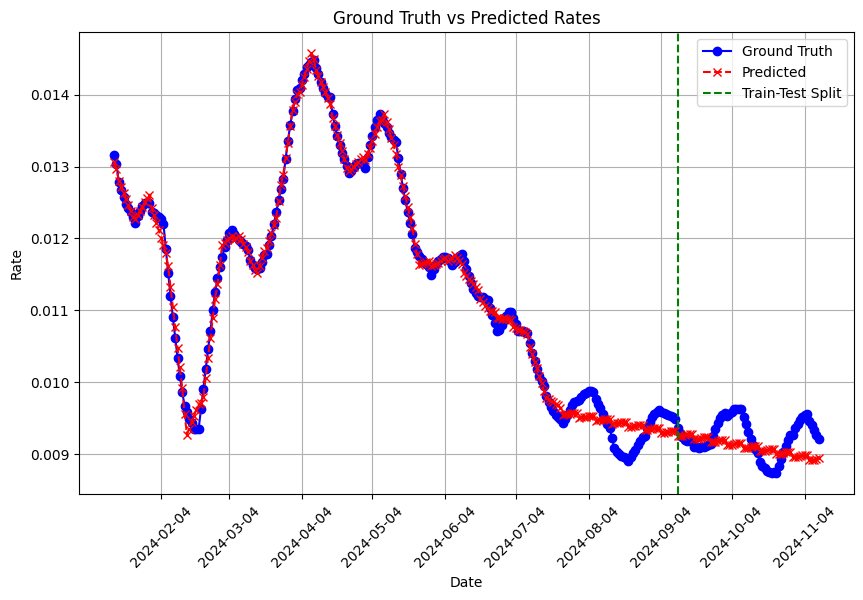

In [105]:
from_date='2024-01-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

period=15

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]
obs_df['dpd30_rate'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

#obs_df['dpd30_rate']=obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()
obs_df=obs_df[~obs_df['dpd30_rate'].isnull()]

base_date = pd.to_datetime(from_date)
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'dpd30_rate','flag','max_dpd']].rename(columns={'dpd30_rate': 'y'})
display(df_prophet.shape)

# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]



# Initialize the Prophet model and add 'date_diff' as an additional regressor
#model = Prophet(holidays=holidays,changepoints=changepoint_dates)
model = Prophet(#holidays=holidays,
                   growth='linear',                      # Linear growth
                #changepoint_range =0.9,
                #seasonality_mode='multiplicative',
    changepoint_prior_scale=1,           # More flexible trend
    #seasonality_prior_scale=10.0,          # Strong seasonality
    holidays_prior_scale=1.0,             # Strong holiday effect
    #seasonality_mode='additive',           # Additive seasonality
    interval_width=0.9,                   # 95% prediction intervals
    daily_seasonality=False,                # Include daily seasonality
    yearly_seasonality=False                # Include yearly seasonality
               
               )
#model.add_regressor('flag')
#model.add_regressor('max_dpd')
#model.add_seasonality(name='monthly_spike', period=30, fourier_order=4)

# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff','flag','max_dpd']], on='ds', how='left')
future['ds']=future['ds'].astype(str)
future[['nearest_4th', 'date_diff']] = future['ds'].apply(nearest_4th_diff).apply(pd.Series)


# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'dpd30_rate','date_diff','flag','max_dpd']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat']))
mae = mean_absolute_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])
mse = mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['dpd30_rate'] - comparison['yhat']) / comparison['dpd30_rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})



# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))

comparison['ds'] = comparison['ds'].astype(str)


# Plot ground truth and predicted values
plt.plot(comparison['ds'], comparison['dpd30_rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')

# Fill the prediction interval
#plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')

# Add a vertical line for the train-test split
test_start_date = df_test['ds'].iloc[0]  # First date of the test set
plt.axvline(x=test_start_date.strftime('%Y-%m-%d'), color='green', linestyle='--', label='Train-Test Split')

# Set x-axis labels to show only the 4th of each month
tick_dates = [date for date in comparison['ds'] if int(date[5:7]) % 1 == 0 and int(date[8:10]) == 4]
plt.xticks(ticks=tick_dates, rotation=45)

# Title, labels, legend, and grid
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [106]:
display(metrics_df)

,Metric,Value
0,RMSE,1.895148e-04
1,MAE,1.331859e-04
2,MSE,3.591585e-08
3,MAPE,1.343652e+00


### Last 21 days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


(295, 4)

08:27:56 - cmdstanpy - INFO - Chain [1] start processing
08:27:57 - cmdstanpy - INFO - Chain [1] done processing


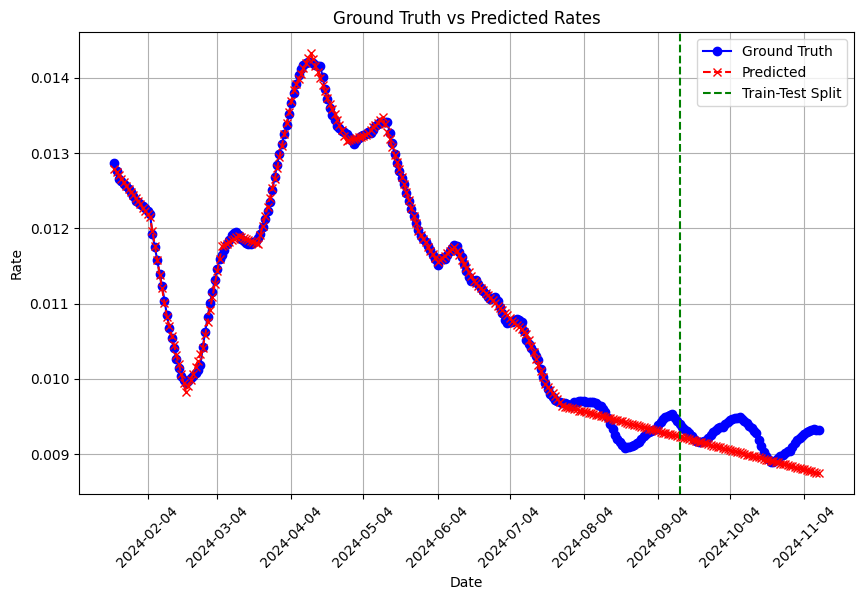

In [107]:
from_date='2024-01-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])


period=21

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]
obs_df['dpd30_rate'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

#obs_df['dpd30_rate']=obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()
obs_df=obs_df[~obs_df['dpd30_rate'].isnull()]

base_date = pd.to_datetime(from_date)
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'dpd30_rate','flag','max_dpd']].rename(columns={'dpd30_rate': 'y'})
display(df_prophet.shape)

# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]



# Initialize the Prophet model and add 'date_diff' as an additional regressor
#model = Prophet(holidays=holidays,changepoints=changepoint_dates)
model = Prophet(#holidays=holidays,
                   growth='linear',                      # Linear growth
                #changepoint_range =0.9,
                #seasonality_mode='multiplicative',
    changepoint_prior_scale=1,           # More flexible trend
    #seasonality_prior_scale=10.0,          # Strong seasonality
    holidays_prior_scale=1.0,             # Strong holiday effect
    #seasonality_mode='additive',           # Additive seasonality
    interval_width=0.9,                   # 95% prediction intervals
    daily_seasonality=False,                # Include daily seasonality
    yearly_seasonality=False                # Include yearly seasonality
               
               )
#model.add_regressor('flag')
#model.add_regressor('max_dpd')
#model.add_seasonality(name='monthly_spike', period=30, fourier_order=4)

# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff','flag','max_dpd']], on='ds', how='left')
future['ds']=future['ds'].astype(str)
future[['nearest_4th', 'date_diff']] = future['ds'].apply(nearest_4th_diff).apply(pd.Series)


# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'dpd30_rate','date_diff','flag','max_dpd']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat']))
mae = mean_absolute_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])
mse = mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['dpd30_rate'] - comparison['yhat']) / comparison['dpd30_rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})



# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))

comparison['ds'] = comparison['ds'].astype(str)


# Plot ground truth and predicted values
plt.plot(comparison['ds'], comparison['dpd30_rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')

# Fill the prediction interval
#plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')

# Add a vertical line for the train-test split
test_start_date = df_test['ds'].iloc[0]  # First date of the test set
plt.axvline(x=test_start_date.strftime('%Y-%m-%d'), color='green', linestyle='--', label='Train-Test Split')

# Set x-axis labels to show only the 4th of each month
tick_dates = [date for date in comparison['ds'] if int(date[5:7]) % 1 == 0 and int(date[8:10]) == 4]
plt.xticks(ticks=tick_dates, rotation=45)

# Title, labels, legend, and grid
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [108]:
display(metrics_df)

,Metric,Value
0,RMSE,1.604775e-04
1,MAE,9.953134e-05
2,MSE,2.575301e-08
3,MAPE,1.012076e+00


### Last 30 days

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
08:28:16 - cmdstanpy - INFO - Chain [1] start processing
08:28:16 - cmdstanpy - INFO - Chain [1] done processing


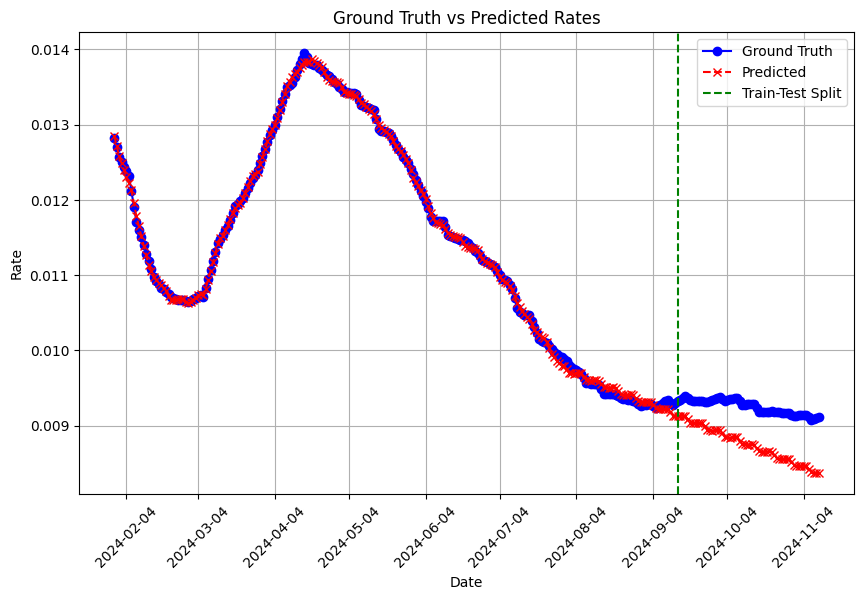

In [109]:
from_date='2024-01-01'
# Assuming input_df is your DataFrame and holidays is already defined
# Base date and adding 'ds' column with sequential dates
input_df['date_balance'] = pd.to_datetime(input_df['date_balance'])

period=30

obs_df=input_df[input_df['date_balance']>=pd.to_datetime(from_date)]
obs_df['dpd30_rate'] = obs_df['dpd30_rate'].rolling(window=period, center=False).mean(std=0.5)

#obs_df['dpd30_rate']=obs_df['dpd30_rate'].ewm(span=period, adjust=True, min_periods=period).mean()
obs_df=obs_df[~obs_df['dpd30_rate'].isnull()]

base_date = pd.to_datetime(from_date)
obs_df['ds'] = obs_df['date_balance']

# Prepare the data for Prophet with 'rate' as the target variable and 'date_diff' as a regressor
df_prophet = obs_df[['ds', 'dpd30_rate','flag','max_dpd']].rename(columns={'dpd30_rate': 'y'})


# Split the data into train and test sets
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]


# Initialize the Prophet model and add 'date_diff' as an additional regressor
model = Prophet(#holidays=holidays,
                   growth='linear',                      # Linear growth

    changepoint_prior_scale=1,           # More flexible trend
    #seasonality_prior_scale=10.0,          # Strong seasonality
    holidays_prior_scale=1.0,             # Strong holiday effect
    #seasonality_mode='additive',           # Additive seasonality
    interval_width=0.9,                   # 95% prediction intervals
    daily_seasonality=False,                # Include daily seasonality
    yearly_seasonality=False                # Include yearly seasonality
               
               )


# Fit the Prophet model to the training data
model.fit(df_train)

# Create a future dataframe including 'date_diff' values for both train and test periods
future = model.make_future_dataframe(periods=len(df_test), freq='D')
future = future.merge(obs_df[['ds', 'date_diff','flag','max_dpd']], on='ds', how='left')
future['ds']=future['ds'].astype(str)
future[['nearest_4th', 'date_diff']] = future['ds'].apply(nearest_4th_diff).apply(pd.Series)


# Make predictions
forecast = model.predict(future)

# Merge forecasted results with the actual 'rate' from the test set
comparison = forecast[['ds', 'yhat','yhat_lower','yhat_upper']].merge(obs_df[['ds', 'dpd30_rate','date_diff','flag','max_dpd']], on='ds', how='left')

# Calculate RMSE, MAE, MSE, MAPE
rmse = np.sqrt(mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat']))
mae = mean_absolute_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])
mse = mean_squared_error(comparison[~comparison['dpd30_rate'].isnull()]['dpd30_rate'], comparison[~comparison['dpd30_rate'].isnull()]['yhat'])

# Calculate MAPE
comparison['mape'] = np.abs((comparison['dpd30_rate'] - comparison['yhat']) / comparison['dpd30_rate']) * 100
mape = comparison['mape'].mean()

# Create a DataFrame for metrics results
metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MSE', 'MAPE'],
    'Value': [rmse, mae, mse, mape]
})



# Plot comparison between ground truth (rate) and predicted (yhat)
plt.figure(figsize=(10, 6))

comparison['ds'] = comparison['ds'].astype(str)


# Plot ground truth and predicted values
plt.plot(comparison['ds'], comparison['dpd30_rate'], label='Ground Truth', color='blue', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', color='red', linestyle='--', marker='x')

# Fill the prediction interval
#plt.fill_between(comparison['ds'], comparison['yhat_lower'], comparison['yhat_upper'], color='gray', alpha=0.2, label='Prediction Interval')

# Add a vertical line for the train-test split
test_start_date = df_test['ds'].iloc[0]  # First date of the test set
plt.axvline(x=test_start_date.strftime('%Y-%m-%d'), color='green', linestyle='--', label='Train-Test Split')

# Set x-axis labels to show only the 4th of each month
tick_dates = [date for date in comparison['ds'] if int(date[5:7]) % 1 == 0 and int(date[8:10]) == 4]
plt.xticks(ticks=tick_dates, rotation=45)

# Title, labels, legend, and grid
plt.title('Ground Truth vs Predicted Rates')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [38]:
metrics_df

,Metric,Value
0,RMSE,2.385110e-04
1,MAE,1.285931e-04
2,MSE,5.688750e-08
3,MAPE,1.353247e+00


With similar settings, a 15-day time frame provides a suitable prediction for the trendline, as it aligns well with the center of the fluctuations. From a metrics perspective, it also offers an optimal balance between capturing trends and minimizing noise.

## Model Evaluation 

The plot above demonstrates that the model accurately captures the peak data points, including both the highest and lowest values of each monthly cycle.

In [150]:
metrics_df

,Metric,Value
0,RMSE,1.895148e-04
1,MAE,1.331859e-04
2,MSE,3.591585e-08
3,MAPE,1.343652e+00


In [138]:
metrics_df

,Metric,Value
0,RMSE,4.665577e-04
1,MAE,3.800088e-04
2,MSE,2.176761e-07
3,MAPE,3.495907e+00
